In [1]:
from cnmodel import populations
from cnmodel.util import sound, random_seed
from cnmodel.protocols import Protocol
from collections import OrderedDict
import os, sys, time
import pickle
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from neuron import h
import multiprocessing as mp
from scipy.signal import savgol_filter
import yaml
import seaborn as sns

--No graphics will be displayed.
[3841109] Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[3841109] Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
[3841109] NumExpr defaulting to 16 threads.


In [2]:
sgc_pop = populations.SGC()
sgc_cfs = sgc_pop._get_cf_array(species='mouse')
b = (sgc_cfs[-1] - sgc_cfs[0]) / np.log(sgc_cfs[-1] / sgc_cfs[0])
a = sgc_cfs[0] - b * np.log(sgc_cfs[0])
sgc_cfs_log = a + b * np.log(sgc_cfs)

## Normal PA Network - 131 cfs 6kHz

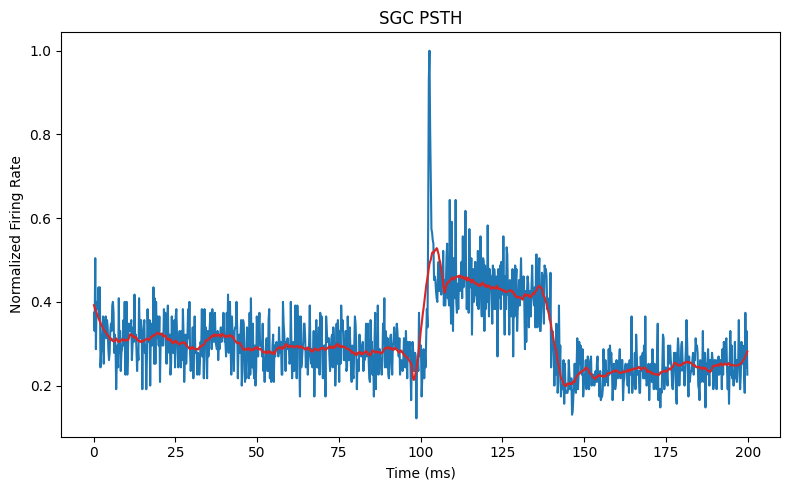

In [ ]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/131cfs_1dbs_6000if_1cpb_1nreps/results_df.pkl', 'rb'))

sgc_msfs = []
sgc_spkts = []

for stim, cells in results.values():
    temp = 6
    for cell_info, cell_data in cells.items():
        if isinstance(cell_info, str):
            continue
        cell_type = cell_info[0]
        cell_id = cell_info[1]
        if 'sgc' in cell_type:

            temp = 8
            spikes = cell_data[1]
            num_spikes = len(spikes)
            num_isi = num_spikes - 1 if num_spikes > 0 else 0
            msf = num_isi / (spikes[-1] - spikes[0])  if num_spikes > 1 else 1
            sgc_msfs.append(msf)
            sgc_spkts.extend(spikes)



sgc_spkts = np.array(sorted(np.array(sgc_spkts)))

bins = np.ceil((sgc_spkts.max() - sgc_spkts.min())/0.2)
y, binedges = np.histogram(sgc_spkts, bins=int(bins))  # returns the right edge of the bins
bincenters = 0.5*(binedges[1:]+binedges[:-1])  # better to use the center of the bins
binsize = bincenters[1] - bincenters[0]  # calculate the width of the bins
rates = y/binsize

fig, axs = plt.subplots(1,1,figsize=(8,5))

axs.plot(bincenters, rates/np.max(rates))
axs.plot(bincenters, savgol_filter(rates/np.max(rates), 50, 3), color='tab:red')
axs.set_title('SGC PSTH')
axs.set_xlabel('Time (ms)')
axs.set_ylabel('Normalized Firing Rate')
fig.tight_layout()

## Normal PA Network - 213 cfs, 22kHz if 40 dB

In [4]:
stimpar = {
    "dur": 0.2,
    "pip": 0.04,
    "start": [0.1],
    "baseline": [50, 100],
    "response": [100, 140],
}

input_freq = 22e3
input_level = 40

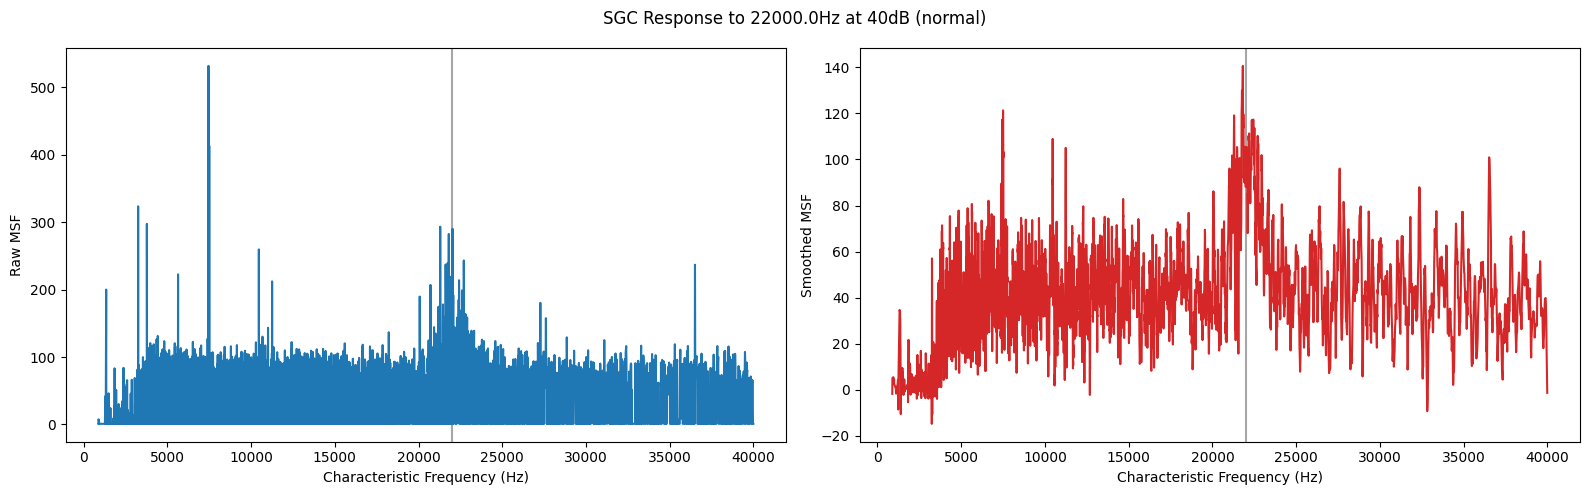

In [48]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))

sgc_msfs = []
n_spikes = []
sgc_ids = []

for stim, iterations in results.values():
    for cell, vec in iterations.items():
        temp = 6
        if 'sgc' in cell[0]:
            spikes = vec[1]
            num_spikes = len(spikes)  #((spikes >= stimpar['response'][0]) & (spikes < stimpar['response'][1])).sum()
            n_spikes.append(num_spikes)  #* (stimpar['response'][1] - stimpar['response'][0]))

            # resp_spkt = spikes[((spikes >= stimpar['response'][0]) & (spikes <= stimpar['response'][1]))]
            # num_spikes = len(spikes)
            num_isi = num_spikes - 1 if num_spikes > 0 else 0
            msf = num_isi / (spikes[-1] - spikes[0]) * 1000 if num_spikes > 1 else 1
            sgc_msfs.append(msf)
            sgc_ids.append(cell[1])

n_spikes = np.array(n_spikes)
sgc_msfs = np.array(sgc_msfs)
nth_avg = 16
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
avg_msfs = ((sgc_msfs + np.roll(sgc_msfs,1))/nth_avg)[1::nth_avg]

fig, axs = plt.subplots(1,2,figsize=(16,5))
axs.ravel()

# axs[0].plot(sgc_cfs[sgc_ids[0::nth_avg]], avg_n_spikes, zorder=12)
# axs[0].plot(sgc_cfs[sgc_ids], n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(sgc_cfs[sgc_ids], savgol_filter(n_spikes, 15, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

# axs[1].plot(sgc_cfs[sgc_ids[0::nth_avg]], avg_msfs, color='k', zorder=12)
axs[0].plot(sgc_cfs[sgc_ids], sgc_msfs, color='tab:blue', zorder=12)
axs[0].set_ylabel('Raw MSF')

axs[1].plot(sgc_cfs[sgc_ids], savgol_filter(sgc_msfs, 15, 3), color='tab:red', zorder=13)
axs[1].set_ylabel('Smoothed MSF')
# axs[1].set_xlim(left=5)
# axs[1].set_ylim([-5, 100])

for ax in axs:

    # ax.axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
    ax.axvline(sgc_cfs[np.abs(np.array(sgc_cfs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(sgc_msfs)//(nticks-1)
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    ax.set_xlabel('Characteristic Frequency (Hz)')
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

fig.suptitle(f'SGC Response to {input_freq}Hz at {input_level}dB (normal)')
fig.tight_layout()

In [41]:
bins = np.ceil((n_spikes.max() - n_spikes.min())/0.1)
bins

np.float64(280.0)

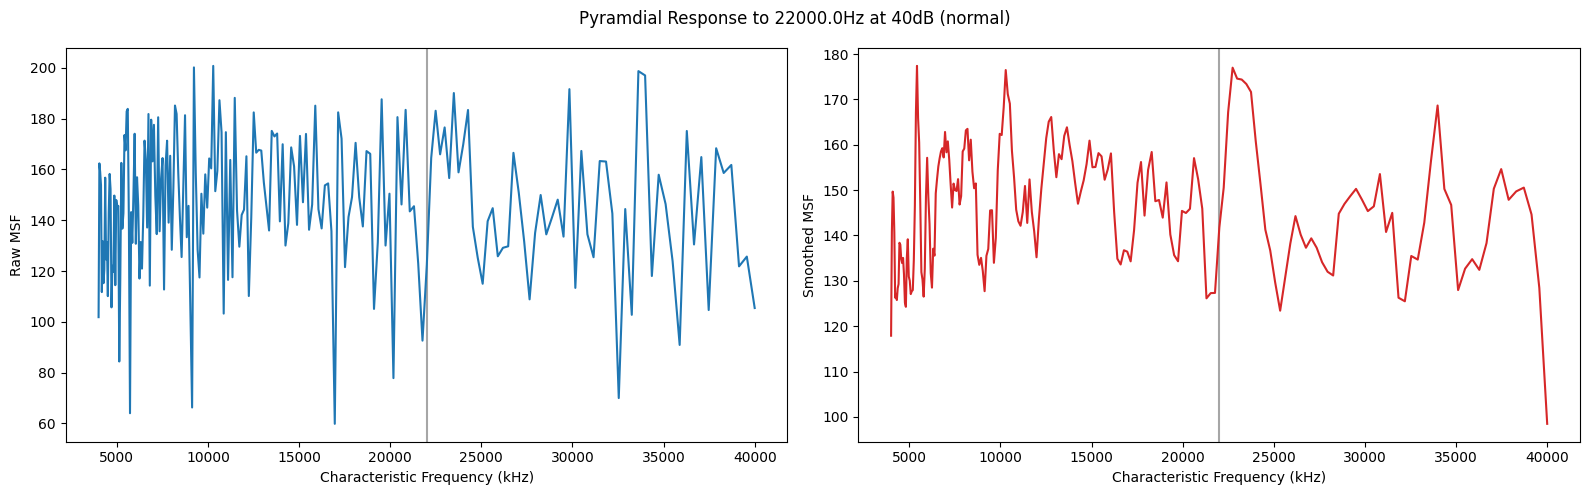

In [49]:
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs = list(pyr_ids_per_band.keys())
b = (freqs[-1] - freqs[0]) / np.log(freqs[-1] / freqs[0])
a = freqs[0] - b * np.log(freqs[0])
freqs_log = a + b * np.log(freqs)

pyr_msfs = []
n_spikes = []

for stim, iterations in results.values():
    for cell, vec in iterations.items():
        temp = 6
        if 'pyr' in cell[0]:
            spikes = vec[1]
            num_spikes = len(spikes)  #((spikes >= stimpar['response'][0]) & (spikes < stimpar['response'][1])).sum()
            n_spikes.append(num_spikes )  #* (stimpar['response'][1] - stimpar['response'][0]))

            # resp_spkt = spikes[((spikes >= stimpar['response'][0]) & (spikes <= stimpar['response'][1]))]
            # num_spikes = len(spikes)
            num_isi = num_spikes - 1 if num_spikes > 0 else 0
            msf = num_isi / (spikes[-1] - spikes[0]) * 1000 if num_spikes > 1 else 1
            pyr_msfs.append(msf)

# loss_inds = freqs[np.where(np.array(freqs) > 30e3)]

fig, axs = plt.subplots(1,2,figsize=(16,5))
axs.ravel()

# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

axs[0].plot(freqs, pyr_msfs, color='tab:blue', zorder=12)
axs[0].set_ylabel('Raw MSF')

axs[1].plot(freqs, savgol_filter(pyr_msfs, 10, 3), color='tab:red', zorder=13)
axs[1].set_ylabel('Smoothed MSF')

for ax in axs:

    # ax.axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
    ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(pyr_msfs)//(nticks-1)
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    ax.set_xlabel('Characteristic Frequency (kHz)')
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

fig.suptitle(f'Pyramdial Response to {input_freq}Hz at {input_level}dB (normal)')
fig.tight_layout()

np.float64(35883.11855734033)

## Hearing Loss PA - 22kHz if at 40dB

In [71]:
spont_spikes = 0
spont_time = 0


for stim, iterations in list(results.values()):
    for cell, vec in iterations.items():
        temp = 6
        if 'sgc' in cell[0]:
            spikes = np.array(vec[1])
            # if len(spikes) > 0:
            spont_spikes += ((spikes >= stimpar['baseline'][0]) * (spikes < stimpar['baseline'][1])).sum()
            spont_time += stimpar['baseline'][1] - stimpar['baseline'][0]

spont_rate = spont_spikes / spont_time


In [81]:
spont_spikes/len(sgc_ids)

np.float64(0.9574144486692016)

In [73]:
spont_rate*40

np.float64(0.7659315589353611)

In [24]:
stimpar = {
    "dur": 0.2,
    "pip": 0.04,
    "start": [0.1],
    "baseline": [50, 100],
    "response": [100, 140],
}

input_freq = 22e3
input_level = 40

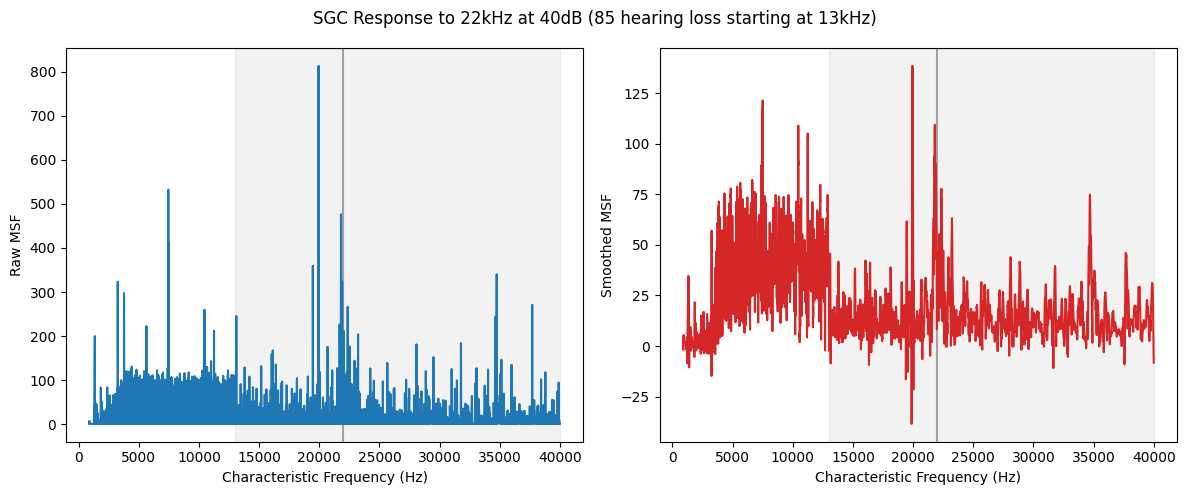

In [45]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_85/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))

sgc_msfs_loss = []
n_spikes = []
sgc_ids_loss = []

for stim, iterations in results.values():
    for cell, vec in iterations.items():
        temp = 6
        if 'sgc' in cell[0]:
            spikes = vec[1]
            num_spikes = len(spikes)  #((spikes >= stimpar['response'][0]) & (spikes < stimpar['response'][1])).sum()
            n_spikes.append(num_spikes)  #* (stimpar['response'][1] - stimpar['response'][0]))

            # resp_spkt = spikes[((spikes >= stimpar['response'][0]) & (spikes <= stimpar['response'][1]))]
            # num_spikes = len(spikes)
            num_isi = num_spikes - 1 if num_spikes > 0 else 0
            msf = num_isi / (spikes[-1] - spikes[0]) * 1000 if num_spikes > 1 else 1
            sgc_msfs_loss.append(msf)
            sgc_ids_loss.append(cell[1])

n_spikes = np.array(n_spikes)
sgc_msfs_loss = np.array(sgc_msfs_loss)
nth_avg = 16
# avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
# avg_msfs = ((msfs + np.roll(msfs,1))/nth_avg)[1::nth_avg]

fig, axs = plt.subplots(1,2,figsize=(12,5))
axs.ravel()

# axs[0].plot(sgc_cfs[sgc_ids], n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(sgc_cfs[sgc_ids], savgol_filter(n_spikes, 15, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

# axs[1].plot(sgc_cfs[sgc_ids[0::nth_avg]], avg_msfs, color='k', zorder=12)
axs[0].plot(sgc_cfs[sgc_ids], sgc_msfs_loss, color='tab:blue', zorder=12)
axs[0].set_ylabel('Raw MSF')

axs[1].plot(sgc_cfs[sgc_ids_loss], savgol_filter(sgc_msfs_loss, 15, 3), color='tab:red', zorder=13)
axs[1].set_ylabel('Smoothed MSF')
# axs[1].set_xlim(left=5)
# axs[1].set_ylim([-5, 100])

loss_inds = sgc_cfs[np.where(sgc_cfs > 13e3)]

for ax in axs:

    ax.axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
    ax.axvline(sgc_cfs[np.abs(np.array(sgc_cfs) - 22e3).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(msfs)//(nticks-1)
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    ax.set_xlabel('Characteristic Frequency (Hz)')
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

fig.suptitle('SGC Response to 22kHz at 40dB (85 hearing loss starting at 13kHz)')
fig.tight_layout()

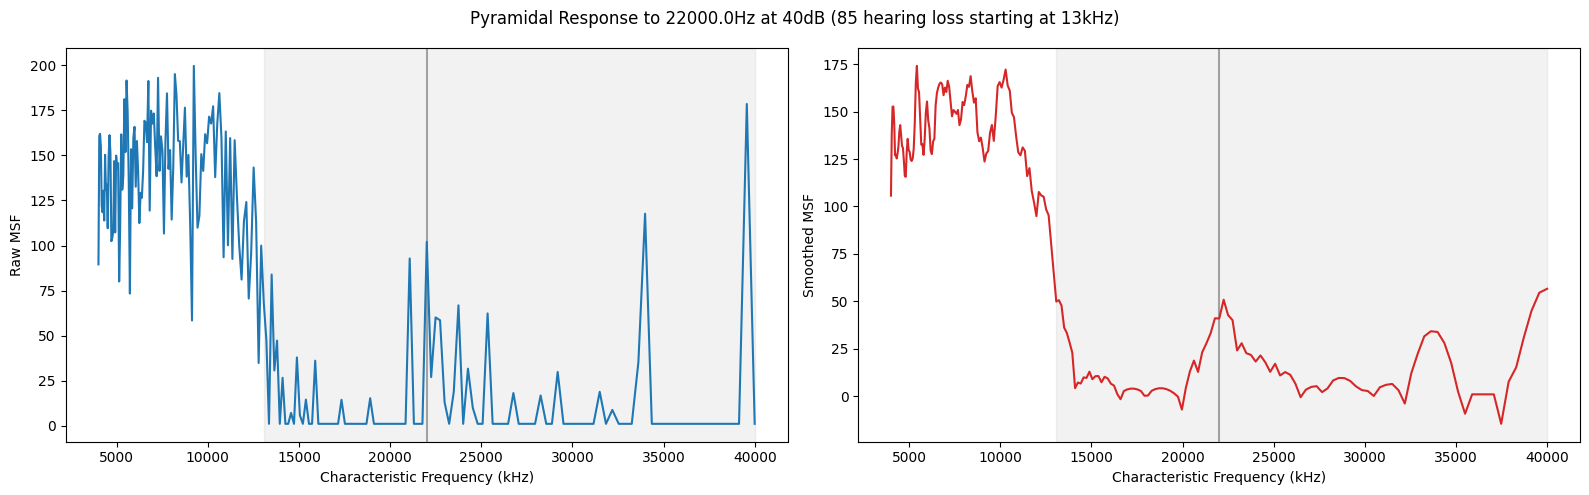

In [47]:
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_85/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs = list(pyr_ids_per_band.keys())
b = (freqs[-1] - freqs[0]) / np.log(freqs[-1] / freqs[0])
a = freqs[0] - b * np.log(freqs[0])
freqs_log = a + b * np.log(freqs)

pyr_msfs_loss = []
n_spikes = []

for stim, iterations in results.values():
    for cell, vec in iterations.items():
        temp = 6
        if 'pyr' in cell[0]:
            spikes = vec[1]
            num_spikes = len(spikes)  #((spikes >= stimpar['response'][0]) & (spikes < stimpar['response'][1])).sum()
            n_spikes.append(num_spikes )  #* (stimpar['response'][1] - stimpar['response'][0]))

            # resp_spkt = spikes[((spikes >= stimpar['response'][0]) & (spikes <= stimpar['response'][1]))]
            # num_spikes = len(spikes)
            num_isi = num_spikes - 1 if num_spikes > 0 else 0
            msf = num_isi / (spikes[-1] - spikes[0]) * 1000 if num_spikes > 1 else 1
            pyr_msfs_loss.append(msf)

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

fig, axs = plt.subplots(1,2,figsize=(16,5))
axs.ravel()

# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

axs[0].plot(freqs, pyr_msfs_loss, color='tab:blue', zorder=12)
axs[0].set_ylabel('Raw MSF')
axs[1].plot(freqs, savgol_filter(pyr_msfs_loss, 10, 3), color='tab:red', zorder=13)
axs[1].set_ylabel('Smoothed MSF')

for ax in axs:

    ax.axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
    ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(pyr_msfs_loss)//(nticks-1)
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    ax.set_xlabel('Characteristic Frequency (kHz)')
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.tight_layout()

## Normal vs Loss - 22kHz at 40dB

In [3]:
stimpar = {
    "dur": 0.2,
    "pip": 0.04,
    "start": [0.1],
    "baseline": [50, 100],
    "response": [100, 140],
}

input_freq = 22e3
input_level = 40

In [3]:
def get_spontaneous_rate(cell_type, results, stimpar):
    spont_spikes = []
    spont_times = []


    for stim, iterations in list(results.values()):
        rep_spont_spikes = []
        for cell, vec in iterations.items():
            temp = 6
            if cell_type in cell[0]:
                spikes = np.array(vec[1])
                # if len(spikes) > 0:
                rep_spont_spikes.append(((spikes >= stimpar['baseline'][0]) * (spikes < stimpar['baseline'][1])).sum())
                # spont_times.append(stimpar['baseline'][1] - stimpar['baseline'][0])
        spont_spikes.append(rep_spont_spikes)

    spont_spikes = np.mean(spont_spikes, axis=0)

    spont_rates = np.array(spont_spikes) / (stimpar['baseline'][1] - stimpar['baseline'][0])
    return spont_rates


In [4]:
def get_cell_nspikes(cell_type, results, response):
    n_spikes = []
    cell_ids = []

    for stim, iterations in results.values():
        rep_n_spikes = []
        rep_cell_ids = []
        for cell, vec in iterations.items():

            if cell_type in cell[0]:
                spikes = np.array(vec[1])
                num_spikes = ((spikes >= response[0]) & (spikes < response[1])).sum()
                rep_n_spikes.append(num_spikes)
                rep_cell_ids.append(cell[1])

        n_spikes.append(rep_n_spikes)
        cell_ids.append(rep_cell_ids)

    n_spikes = np.mean(n_spikes, axis=0)

    return cell_ids[0], np.array(n_spikes)

In [5]:
def get_cell_msfs(cell_type, results, response):
    msfs = []
    cell_ids = []

    for stim, iterations in results.values():
        rep_msfs = []
        rep_cell_ids = []
        for cell, vec in iterations.items():

            if cell_type in cell[0]:
                spikes = np.array(vec[1])
                resp_spikes = spikes[(spikes >= response[0]) & (spikes < response[1])]
                num_spikes = len(resp_spikes)
                num_isi = num_spikes - 1 if num_spikes > 0 else 0
                msf = num_isi / (spikes[-1] - spikes[0]) * 1000 if num_spikes > 1 else 1
                rep_msfs.append(msf)
                rep_cell_ids.append(cell[1])

        msfs.append(rep_msfs)
        cell_ids.append(rep_cell_ids)

    msfs = np.average(msfs, axis=0)

    return cell_ids[0], np.array(msfs)

### Response rate

#### 14K at 60dB - stim for 100ms

In [6]:
stimpar = {
    "dur": 0.26,
    "pip": 0.1,
    "start": [0.1],
    "baseline": [50, 100],
    "response": [100, 200],
}

input_freq = 22e3
input_level = 60

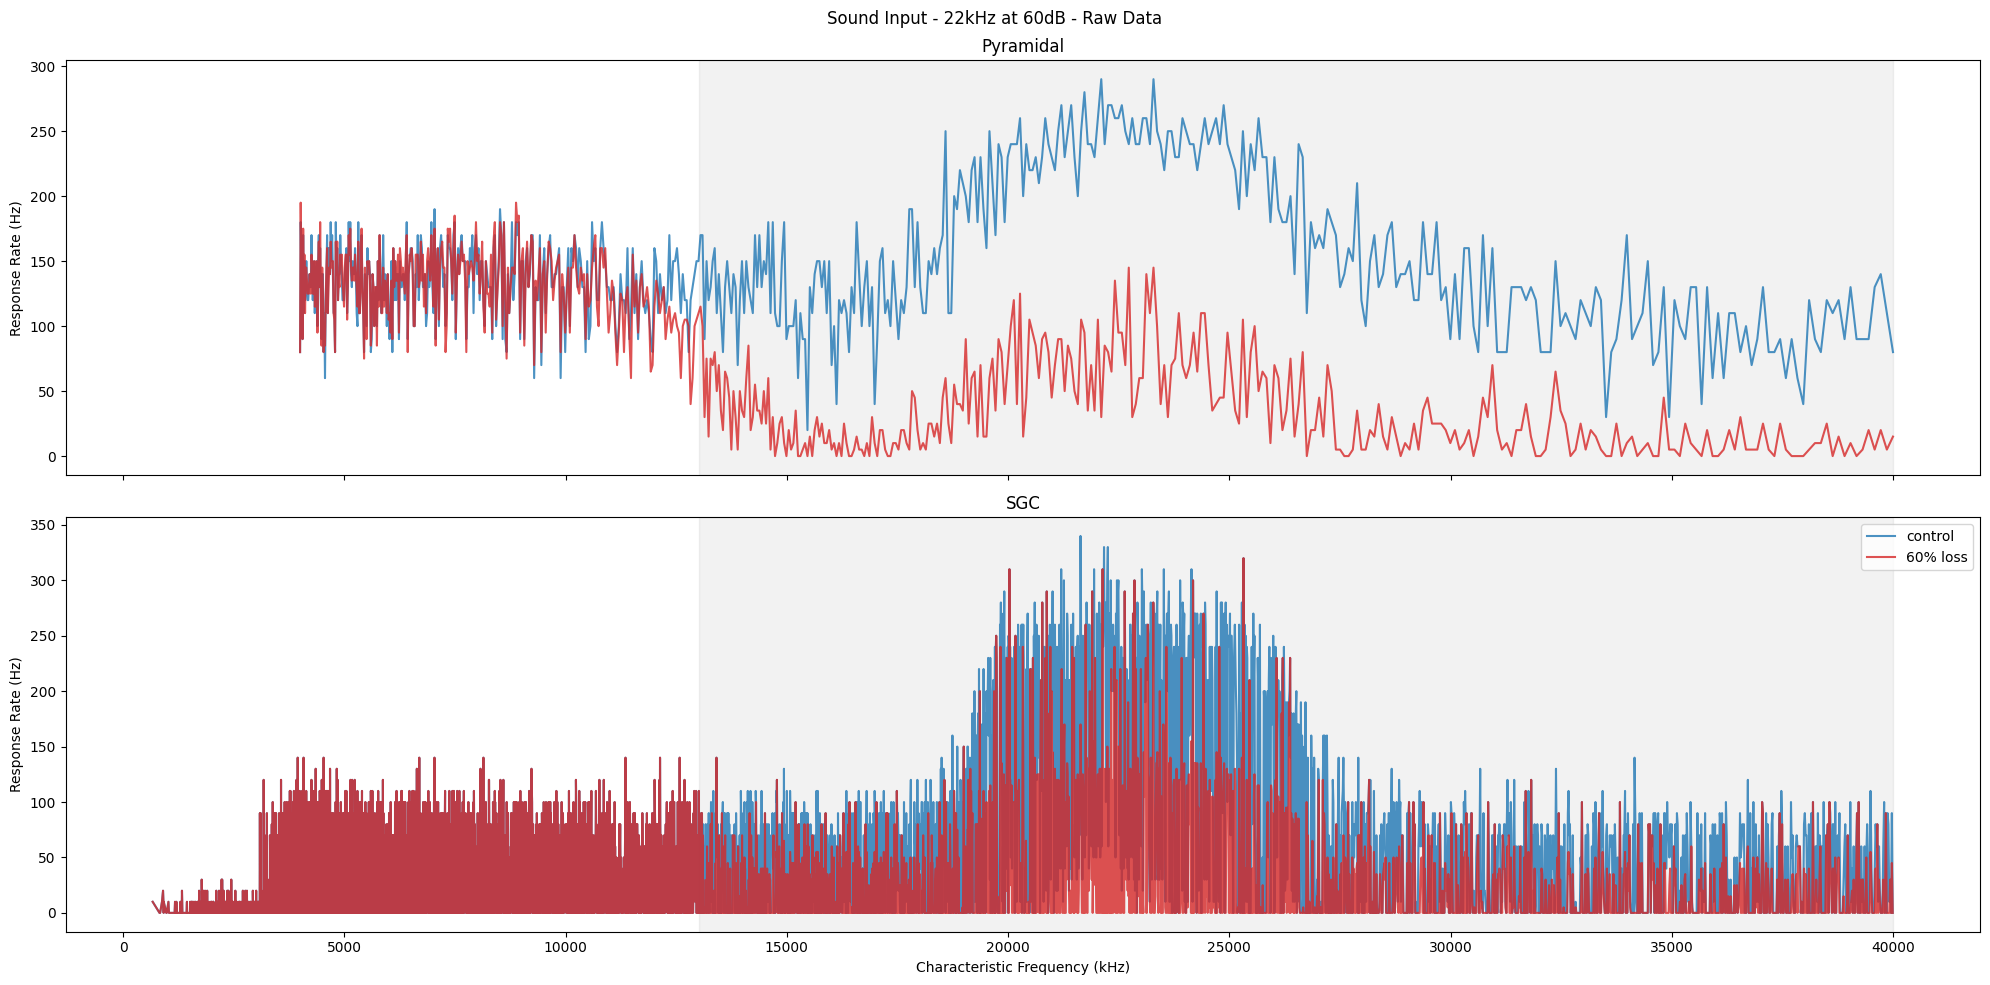

In [ ]:
n_cfs = 665
n_reps = 2

sim_flag = 'network_longerstim'

results = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs = list(pyr_ids_per_band.keys())
pyr_spont_rates = get_spontaneous_rate('pyramidal', results, stimpar)
sgc_spont_rates = get_spontaneous_rate('sgc', results, stimpar)
pyr_ids, pyr_resp_spikes = get_cell_nspikes('pyramidal', results, stimpar['response'])
sgc_ids, sgc_resp_spikes = get_cell_nspikes('sgc', results, stimpar['response'])

pyr_ids, pyr_resp_msfs = get_cell_msfs('pyramidal', results, stimpar['response'])
sgc_ids, sgc_resp_msfs = get_cell_msfs('sgc', results, stimpar['response'])

n_cfs = 665  # 213 or 665
loss_frac = 60
loss_version = 'm3'
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs_loss = list(pyr_ids_per_band.keys())
pyr_spont_rates_loss = get_spontaneous_rate('pyramidal', results_loss, stimpar)
sgc_spont_rates_loss = get_spontaneous_rate('sgc', results_loss, stimpar)
pyr_ids_loss, pyr_resp_spikes_loss = get_cell_nspikes('pyramidal', results_loss, stimpar['response'])
sgc_ids_loss, sgc_resp_spikes_loss = get_cell_nspikes('sgc', results_loss, stimpar['response'])

pyr_ids_loss, pyr_resp_msfs_loss = get_cell_msfs('pyramidal', results_loss, stimpar['response'])
sgc_ids_loss, sgc_resp_msfs_loss = get_cell_msfs('sgc', results_loss, stimpar['response'])

fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)  #, sharey=True)
axs = axs.ravel()

data = (sgc_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates*0
# data = sgc_resp_msfs
axs[1].plot(sgc_cfs[sgc_ids], data, color='tab:blue', zorder=13, alpha=0.8, label='control')
axs[1].set_title('SGC (control)')

data = (sgc_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates_loss*0 
# data = sgc_resp_msfs_loss
axs[1].plot(sgc_cfs[sgc_ids_loss], data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[1].set_title(f"SGC")

data = (pyr_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates*0 
# data = pyr_resp_msfs
axs[0].plot(freqs, data, color='tab:blue', zorder=13, alpha=0.8, label='control')

data = (pyr_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates_loss*0 
# data = pyr_resp_msfs_loss
axs[0].plot(freqs_loss, data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[0].set_title(f'Pyramidal')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

for ax in axs:

    # ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    # xtick_span = len(pyr_msfs_loss)//(nticks-1)
    # ax.set_ylim([-10,210])
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

axs[1].legend(loc='upper right')

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Response Rate (Hz)')
axs[1].set_ylabel('Response Rate (Hz)')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB - Raw Data")
fig.tight_layout()
filename = f'22kHz_60dB-{loss_version}_{loss_frac}'
fig.savefig(f'{filename}.pdf', dpi=300)
fig.savefig(f'{filename}.png', dpi=300)

In [31]:
np.where(sgc_resp_spikes==0)

(array([   1,    2,    6, ..., 5738, 5743, 5745], shape=(2289,)),)

In [30]:
np.where(sgc_resp_spikes_loss==0)

(array([   1,    3,    4, ..., 5256, 5258, 5259], shape=(2255,)),)

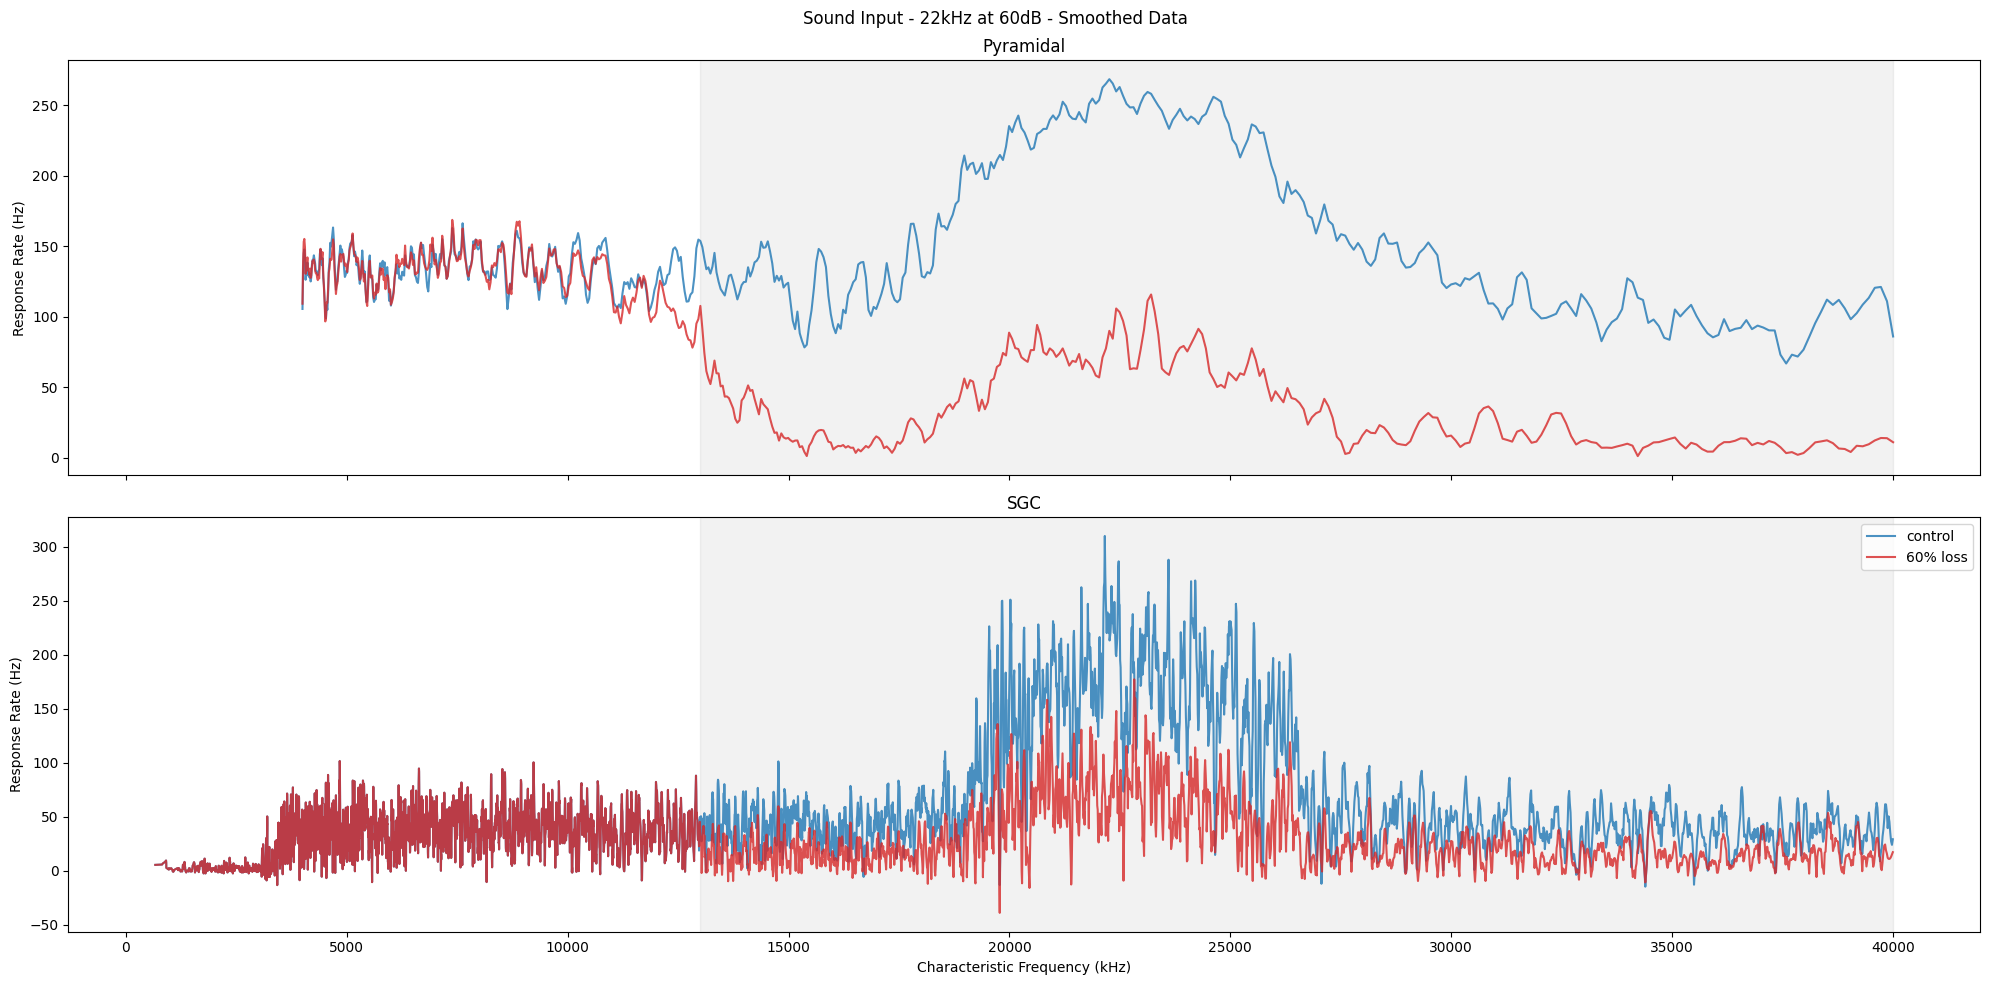

In [8]:
n_cfs = 665
n_reps = 2

sim_flag = 'network_longerstim'

results = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs = list(pyr_ids_per_band.keys())
pyr_spont_rates = get_spontaneous_rate('pyramidal', results, stimpar)
sgc_spont_rates = get_spontaneous_rate('sgc', results, stimpar)
pyr_ids, pyr_resp_spikes = get_cell_nspikes('pyramidal', results, stimpar['response'])
sgc_ids, sgc_resp_spikes = get_cell_nspikes('sgc', results, stimpar['response'])

n_cfs = 665  # 213 or 665
loss_frac = 60
loss_version = 'm3'
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-{sim_flag}_13000loss-{loss_version}_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs_loss = list(pyr_ids_per_band.keys())
pyr_spont_rates_loss = get_spontaneous_rate('pyramidal', results_loss, stimpar)
sgc_spont_rates_loss = get_spontaneous_rate('sgc', results_loss, stimpar)
pyr_ids_loss, pyr_resp_spikes_loss = get_cell_nspikes('pyramidal', results_loss, stimpar['response'])
sgc_ids_loss, sgc_resp_spikes_loss = get_cell_nspikes('sgc', results_loss, stimpar['response'])

fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)  #, sharey=True)
axs = axs.ravel()


win_length = 10
polyorder = 3
# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')
# - sgc_spont_rates*(stimpar['response'][1] - stimpar['response'][0])
nth_avg = 6
n_spikes = sgc_resp_spikes - 0*(stimpar['response'][1] - stimpar['response'][0])
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
# axs[1].plot(sgc_cfs[sgc_ids[0::nth_avg]],  avg_n_spikes, color='tab:blue', zorder=13, alpha=0.8)

data = (sgc_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates*0
filtered_data = savgol_filter(data, win_length, polyorder)
axs[1].plot(sgc_cfs[sgc_ids], filtered_data, color='tab:blue', zorder=13, alpha=0.8, label='control')
axs[1].set_title('SGC (control)')

n_spikes = sgc_resp_spikes_loss - 0*(stimpar['response'][1] - stimpar['response'][0])
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
# axs[1].plot(sgc_cfs[sgc_ids[0::nth_avg]],  avg_n_spikes, color='tab:red', zorder=13, alpha=0.8)
# - sgc_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0])

data =  (sgc_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates_loss*0
filtered_data = savgol_filter(data, win_length, polyorder)
axs[1].plot(sgc_cfs[sgc_ids_loss], filtered_data , color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[1].set_title(f"SGC")

nth_avg = 3
n_spikes = pyr_resp_spikes - pyr_spont_rates*(stimpar['response'][1] - stimpar['response'][0])
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
# axs[0].plot(freqs[0::nth_avg], avg_n_spikes, color='tab:blue', zorder=13, alpha=0.8)
# - pyr_spont_rates*(stimpar['response'][1] - stimpar['response'][0])

data =  (pyr_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates*0
filtered_data = savgol_filter(data, win_length, polyorder)
axs[0].plot(freqs, filtered_data , color='tab:blue', zorder=13, alpha=0.8, label='control')

n_spikes = pyr_resp_spikes_loss - pyr_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0])
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
# axs[0].plot(freqs[0::nth_avg],  avg_n_spikes, color='tab:red', zorder=13, alpha=0.8)
# - pyr_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0])

data =  (pyr_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates_loss*0
filtered_data = savgol_filter(data, win_length, polyorder)
axs[0].plot(freqs_loss, filtered_data, color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[0].set_title(f'Pyramidal')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

for ax in axs:

    # ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    # xtick_span = len(pyr_msfs_loss)//(nticks-1)
    # ax.set_ylim([-10,210])
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

axs[1].legend(loc='upper right')

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Response Rate (Hz)')
axs[1].set_ylabel('Response Rate (Hz)')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB - Smoothed Data")
fig.tight_layout()
filename = f'22kHz_60dB-{loss_version}_{loss_frac}-smoothed'
fig.savefig(f'{filename}.pdf', dpi=300)
fig.savefig(f'{filename}.png', dpi=300)

#### 14k at 40dB - stim for 40ms

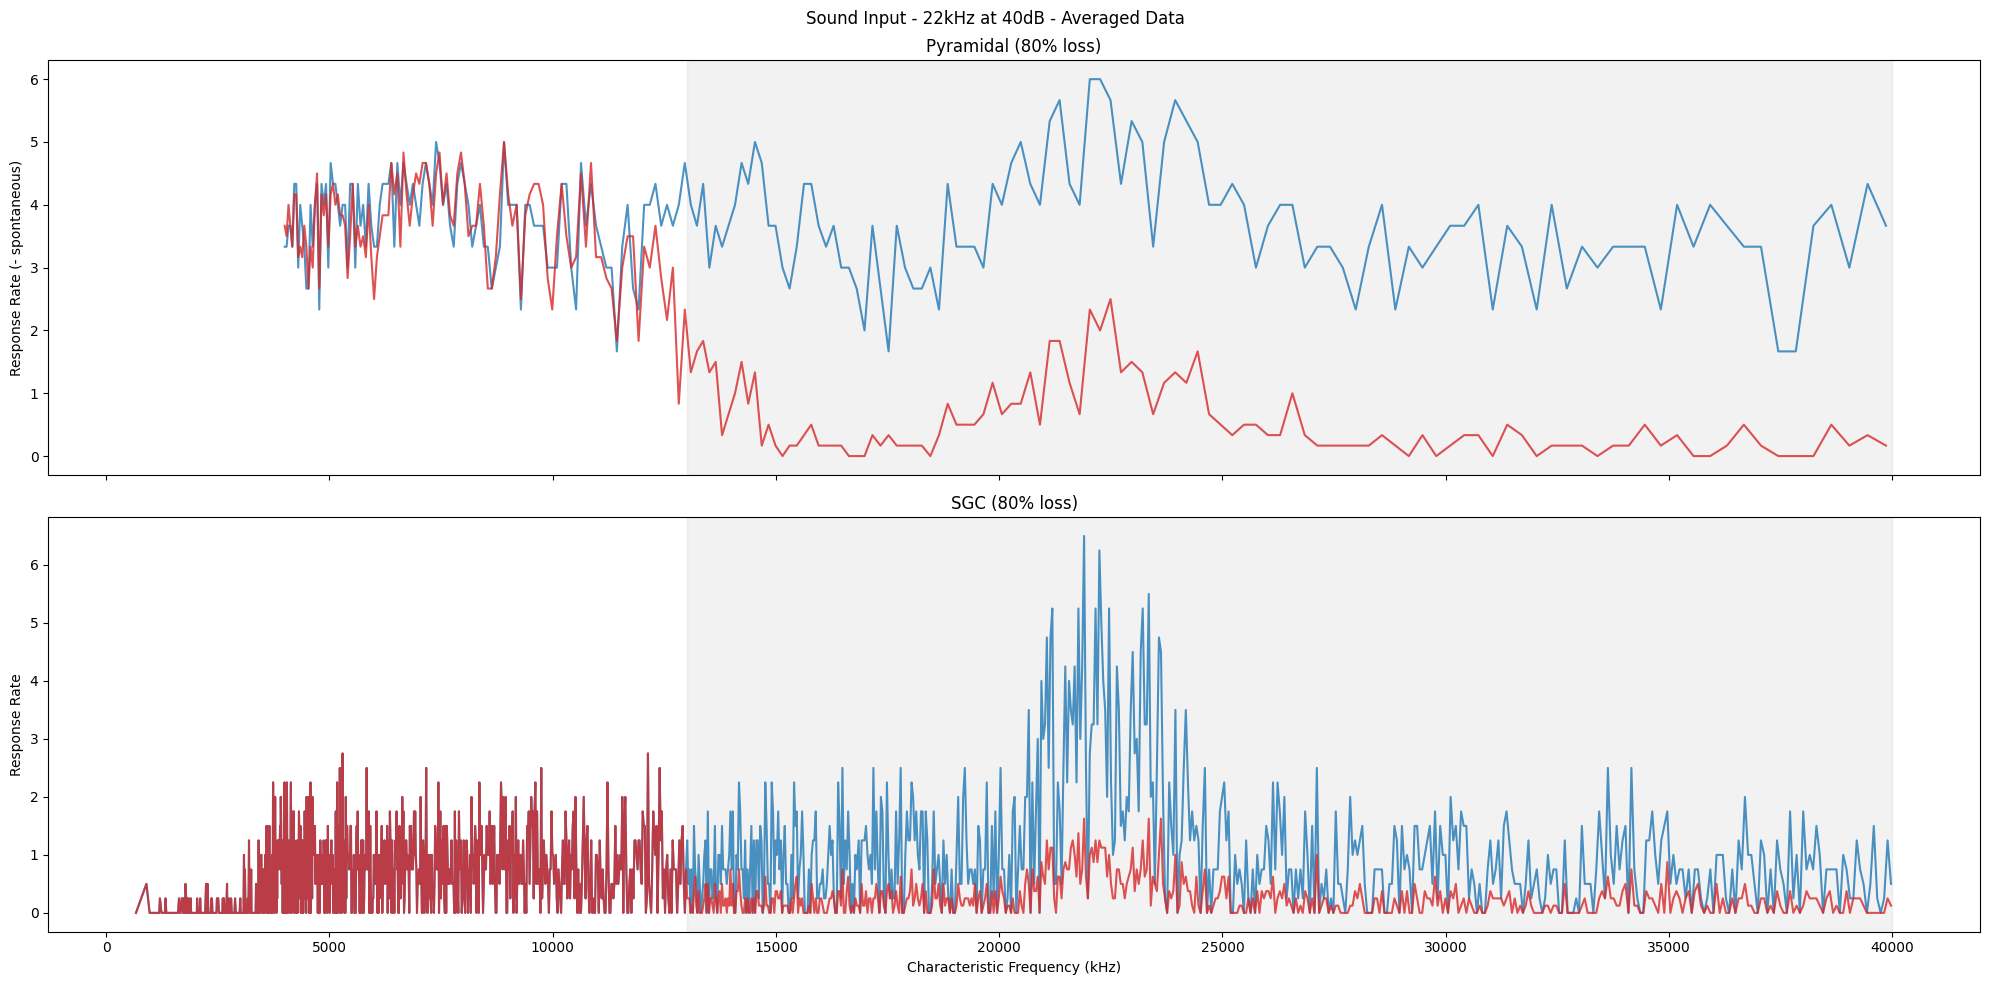

In [34]:
n_cfs = 665
n_reps = 2

results = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs = list(pyr_ids_per_band.keys())
pyr_spont_rates = get_spontaneous_rate('pyramidal', results)
sgc_spont_rates = get_spontaneous_rate('sgc', results)
pyr_ids, pyr_resp_spikes = get_cell_nspikes('pyramidal', results, stimpar['response'])
sgc_ids, sgc_resp_spikes = get_cell_nspikes('sgc', results, stimpar['response'])

loss_frac = 80
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs_loss = list(pyr_ids_per_band.keys())
pyr_spont_rates_loss = get_spontaneous_rate('pyramidal', results_loss)
sgc_spont_rates_loss = get_spontaneous_rate('sgc', results_loss)
pyr_ids_loss, pyr_resp_spikes_loss = get_cell_nspikes('pyramidal', results_loss, stimpar['response'])
sgc_ids_loss, sgc_resp_spikes_loss = get_cell_nspikes('sgc', results_loss, stimpar['response'])

fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)  #, sharey=True)
axs = axs.ravel()


win_length = 10
polyorder = 3
# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')
# - sgc_spont_rates*(stimpar['response'][1] - stimpar['response'][0])
nth_avg = 4
n_spikes = sgc_resp_spikes - 0*(stimpar['response'][1] - stimpar['response'][0])
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
axs[1].plot(sgc_cfs[sgc_ids[0::nth_avg]],  avg_n_spikes, color='tab:blue', zorder=13, alpha=0.8)
# axs[1].plot(sgc_cfs[sgc_ids], savgol_filter(sgc_resp_spikes- sgc_spont_rates*(stimpar['response'][1] - stimpar['response'][0]), win_length, 3) , color='tab:blue', zorder=13, alpha=0.8)
# axs[1].plot(sgc_cfs[sgc_ids], savgol_filter(sgc_resp_spikes, win_length, polyorder) , color='tab:blue', zorder=13, alpha=0.8)
# axs[1].plot(sgc_cfs[sgc_ids], sgc_resp_spikes - sgc_spont_rates*(stimpar['response'][1] - stimpar['response'][0]) , color='tab:blue', zorder=13, alpha=0.8)
axs[1].set_title('SGC (control)')

n_spikes = sgc_resp_spikes_loss - 0*(stimpar['response'][1] - stimpar['response'][0])
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
axs[1].plot(sgc_cfs[sgc_ids[0::nth_avg]],  avg_n_spikes, color='tab:red', zorder=13, alpha=0.8)
# - sgc_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0])
# axs[1].plot(sgc_cfs[sgc_ids_loss], savgol_filter(sgc_resp_spikes_loss- sgc_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0]), win_length, 3) , color='tab:red', zorder=13, alpha=0.8)
# axs[1].plot(sgc_cfs[sgc_ids_loss], savgol_filter(sgc_resp_spikes_loss, win_length, polyorder) , color='tab:red', zorder=13, alpha=0.8)
# axs[1].plot(sgc_cfs[sgc_ids_loss], sgc_resp_spikes_loss - sgc_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0]) , color='tab:red', zorder=13, alpha=0.8)
axs[1].set_title(f"SGC ({loss_frac}% loss)")

nth_avg = 3
n_spikes = pyr_resp_spikes - 0*(stimpar['response'][1] - stimpar['response'][0])
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
axs[0].plot(freqs[0::nth_avg], avg_n_spikes, color='tab:blue', zorder=13, alpha=0.8)
# - pyr_spont_rates*(stimpar['response'][1] - stimpar['response'][0])
# axs[0].plot(freqs, savgol_filter(pyr_resp_spikes- pyr_spont_rates*(stimpar['response'][1] - stimpar['response'][0]), win_length, polyorder) , color='tab:blue', zorder=13, alpha=0.8)
# axs[0].plot(freqs, savgol_filter(pyr_resp_spikes, win_length, polyorder) , color='tab:blue', zorder=13, alpha=0.8)
# axs[0].plot(freqs, pyr_resp_spikes - pyr_spont_rates*(stimpar['response'][1] - stimpar['response'][0]) , color='tab:blue', zorder=13, alpha=0.8)
axs[0].set_title('Pyramidal (control)')

n_spikes = pyr_resp_spikes_loss - 0*(stimpar['response'][1] - stimpar['response'][0])
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
axs[0].plot(freqs[0::nth_avg],  avg_n_spikes, color='tab:red', zorder=13, alpha=0.8)
# - pyr_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0])
# axs[0].plot(freqs, savgol_filter(pyr_resp_spikes_loss- pyr_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0]), win_length, polyorder) , color='tab:red', zorder=13, alpha=0.8)
# axs[0].plot(freqs, savgol_filter(pyr_resp_spikes_loss, win_length, polyorder) , color='tab:red', zorder=13, alpha=0.8)
# axs[0].plot(freqs, pyr_resp_spikes_loss - pyr_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0]) , color='tab:red', zorder=13, alpha=0.8)
axs[0].set_title(f'Pyramidal ({loss_frac}% loss)')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

for ax in axs:

    # ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    # xtick_span = len(pyr_msfs_loss)//(nticks-1)
    # ax.set_ylim([-10,210])
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Response Rate (- spontaneous)')
axs[1].set_ylabel('Response Rate')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB - Averaged Data")
fig.tight_layout()

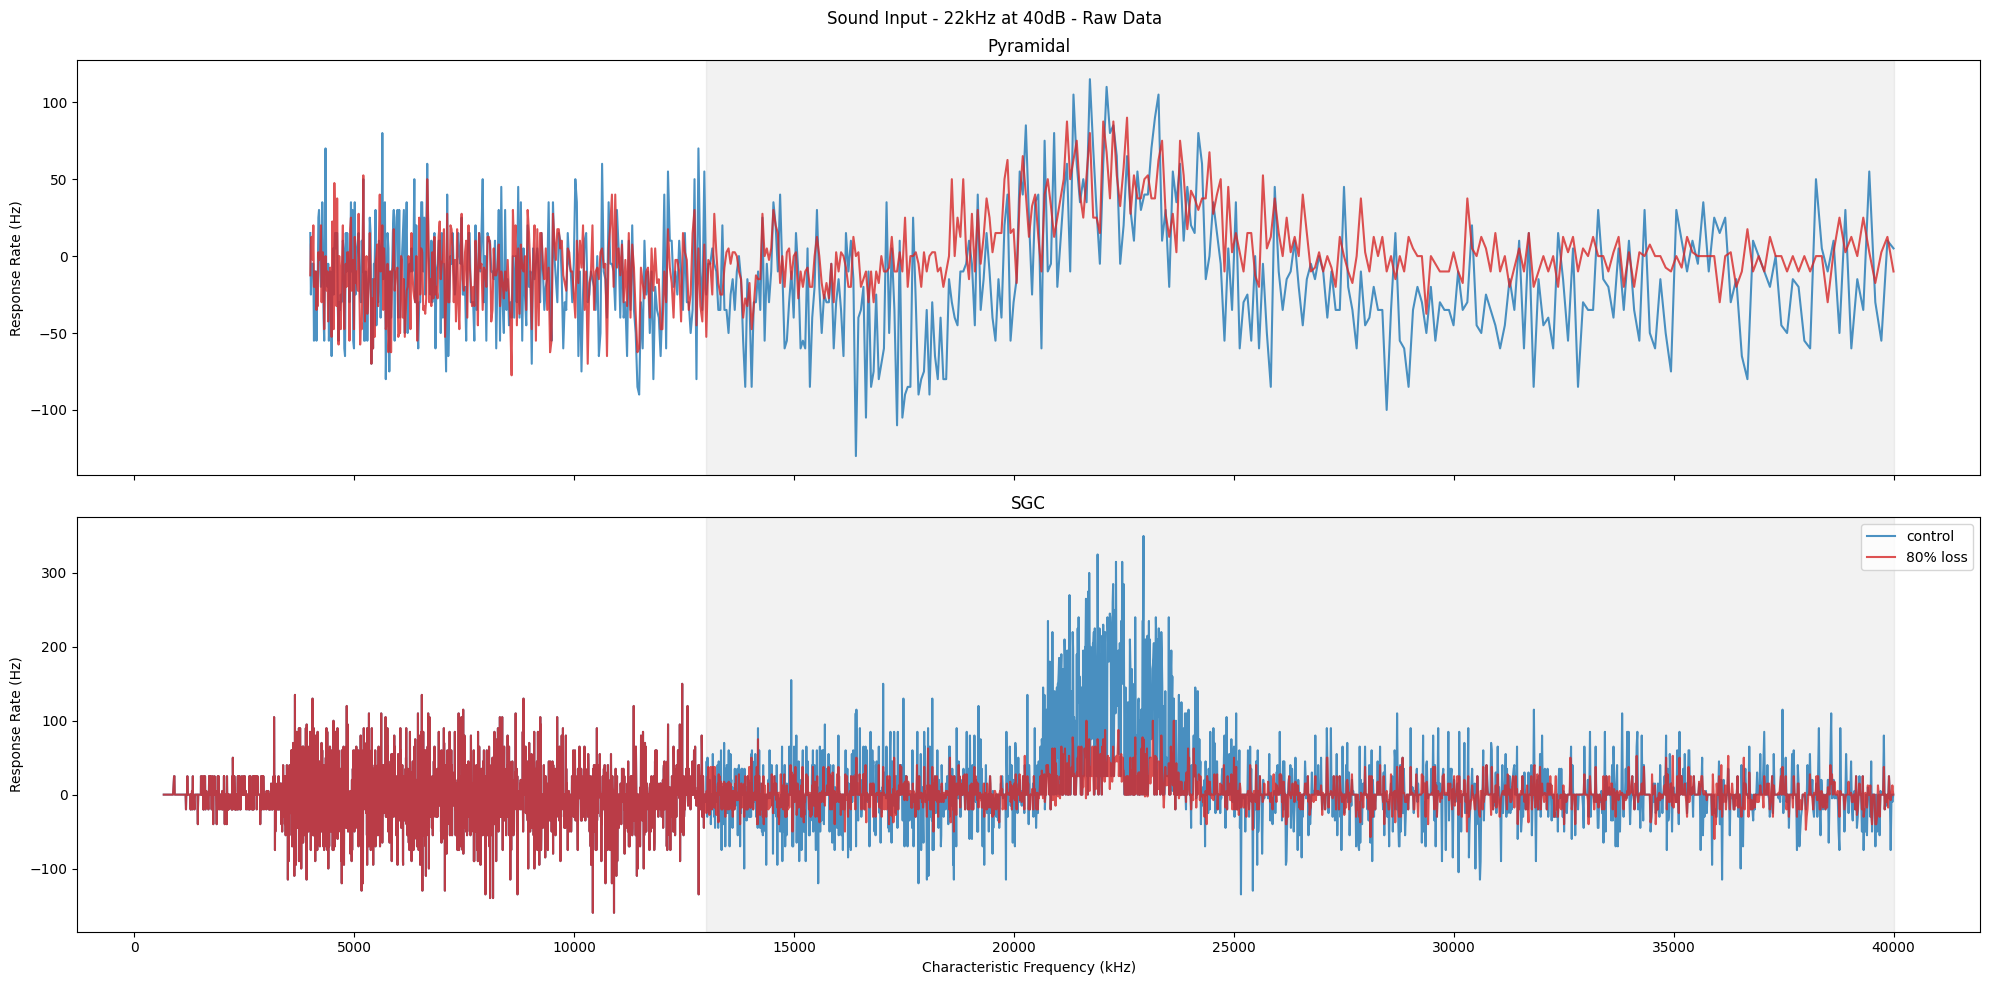

In [15]:
n_cfs = 665
n_reps = 2

results = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs = list(pyr_ids_per_band.keys())
pyr_spont_rates = get_spontaneous_rate('pyramidal', results)
sgc_spont_rates = get_spontaneous_rate('sgc', results)
pyr_ids, pyr_resp_spikes = get_cell_nspikes('pyramidal', results, stimpar['response'])
sgc_ids, sgc_resp_spikes = get_cell_nspikes('sgc', results, stimpar['response'])

loss_frac = 80
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs_loss = list(pyr_ids_per_band.keys())
pyr_spont_rates_loss = get_spontaneous_rate('pyramidal', results_loss)
sgc_spont_rates_loss = get_spontaneous_rate('sgc', results_loss)
pyr_ids_loss, pyr_resp_spikes_loss = get_cell_nspikes('pyramidal', results_loss, stimpar['response'])
sgc_ids_loss, sgc_resp_spikes_loss = get_cell_nspikes('sgc', results_loss, stimpar['response'])

fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)  #, sharey=True)
axs = axs.ravel()


win_length = 10
polyorder = 3
# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')
# - sgc_spont_rates*(stimpar['response'][1] - stimpar['response'][0])
nth_avg = 6
n_spikes = sgc_resp_spikes - 0*(stimpar['response'][1] - stimpar['response'][0])
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
# axs[1].plot(sgc_cfs[sgc_ids[0::nth_avg]],  avg_n_spikes, color='tab:blue', zorder=13, alpha=0.8)
# axs[1].plot(sgc_cfs[sgc_ids], savgol_filter(sgc_resp_spikes- sgc_spont_rates*(stimpar['response'][1] - stimpar['response'][0]), win_length, 3) , color='tab:blue', zorder=13, alpha=0.8)
# axs[1].plot(sgc_cfs[sgc_ids], savgol_filter(sgc_resp_spikes, win_length, polyorder) , color='tab:blue', zorder=13, alpha=0.8)
axs[1].plot(sgc_cfs[sgc_ids], (sgc_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates*1000 , color='tab:blue', zorder=13, alpha=0.8, label='control')
axs[1].set_title('SGC (control)')

n_spikes = sgc_resp_spikes_loss - 0*(stimpar['response'][1] - stimpar['response'][0])
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
# axs[1].plot(sgc_cfs[sgc_ids[0::nth_avg]],  avg_n_spikes, color='tab:red', zorder=13, alpha=0.8)
# - sgc_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0])
# axs[1].plot(sgc_cfs[sgc_ids_loss], savgol_filter(sgc_resp_spikes_loss- sgc_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0]), win_length, 3) , color='tab:red', zorder=13, alpha=0.8)
# axs[1].plot(sgc_cfs[sgc_ids_loss], savgol_filter(sgc_resp_spikes_loss, win_length, polyorder) , color='tab:red', zorder=13, alpha=0.8)
axs[1].plot(sgc_cfs[sgc_ids_loss], (sgc_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000) - sgc_spont_rates_loss*1000 , color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[1].set_title(f"SGC")

nth_avg = 3
n_spikes = pyr_resp_spikes - pyr_spont_rates*(stimpar['response'][1] - stimpar['response'][0])
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
# axs[0].plot(freqs[0::nth_avg], avg_n_spikes, color='tab:blue', zorder=13, alpha=0.8)
# - pyr_spont_rates*(stimpar['response'][1] - stimpar['response'][0])
# axs[0].plot(freqs, savgol_filter(pyr_resp_spikes- pyr_spont_rates*(stimpar['response'][1] - stimpar['response'][0]), win_length, polyorder) , color='tab:blue', zorder=13, alpha=0.8)
# axs[0].plot(freqs, savgol_filter(pyr_resp_spikes, win_length, polyorder) , color='tab:blue', zorder=13, alpha=0.8)
axs[0].plot(freqs, (pyr_resp_spikes / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates*1000 , color='tab:blue', zorder=13, alpha=0.8, label='control')

n_spikes = pyr_resp_spikes_loss - pyr_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0])
avg_n_spikes = ((n_spikes + np.roll(n_spikes,1))/nth_avg)[1::nth_avg]
# axs[0].plot(freqs[0::nth_avg],  avg_n_spikes, color='tab:red', zorder=13, alpha=0.8)
# - pyr_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0])
# axs[0].plot(freqs, savgol_filter(pyr_resp_spikes_loss- pyr_spont_rates_loss*(stimpar['response'][1] - stimpar['response'][0]), win_length, polyorder) , color='tab:red', zorder=13, alpha=0.8)
# axs[0].plot(freqs, savgol_filter(pyr_resp_spikes_loss, win_length, polyorder) , color='tab:red', zorder=13, alpha=0.8)
axs[0].plot(freqs, (pyr_resp_spikes_loss / (stimpar['response'][1] - stimpar['response'][0])*1000)-pyr_spont_rates_loss*1000 , color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[0].set_title(f'Pyramidal')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

for ax in axs:

    # ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    # xtick_span = len(pyr_msfs_loss)//(nticks-1)
    # ax.set_ylim([-10,210])
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

axs[1].legend(loc='upper right')

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Response Rate (Hz)')
axs[1].set_ylabel('Response Rate (Hz)')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB - Raw Data")
fig.tight_layout()

In [18]:
pyr_spont_rates.max(), pyr_spont_rates_loss.max()

(np.float64(0.24), np.float64(0.22))

In [47]:
(stimpar['response'][1] - stimpar['response'][0])/1000

0.04

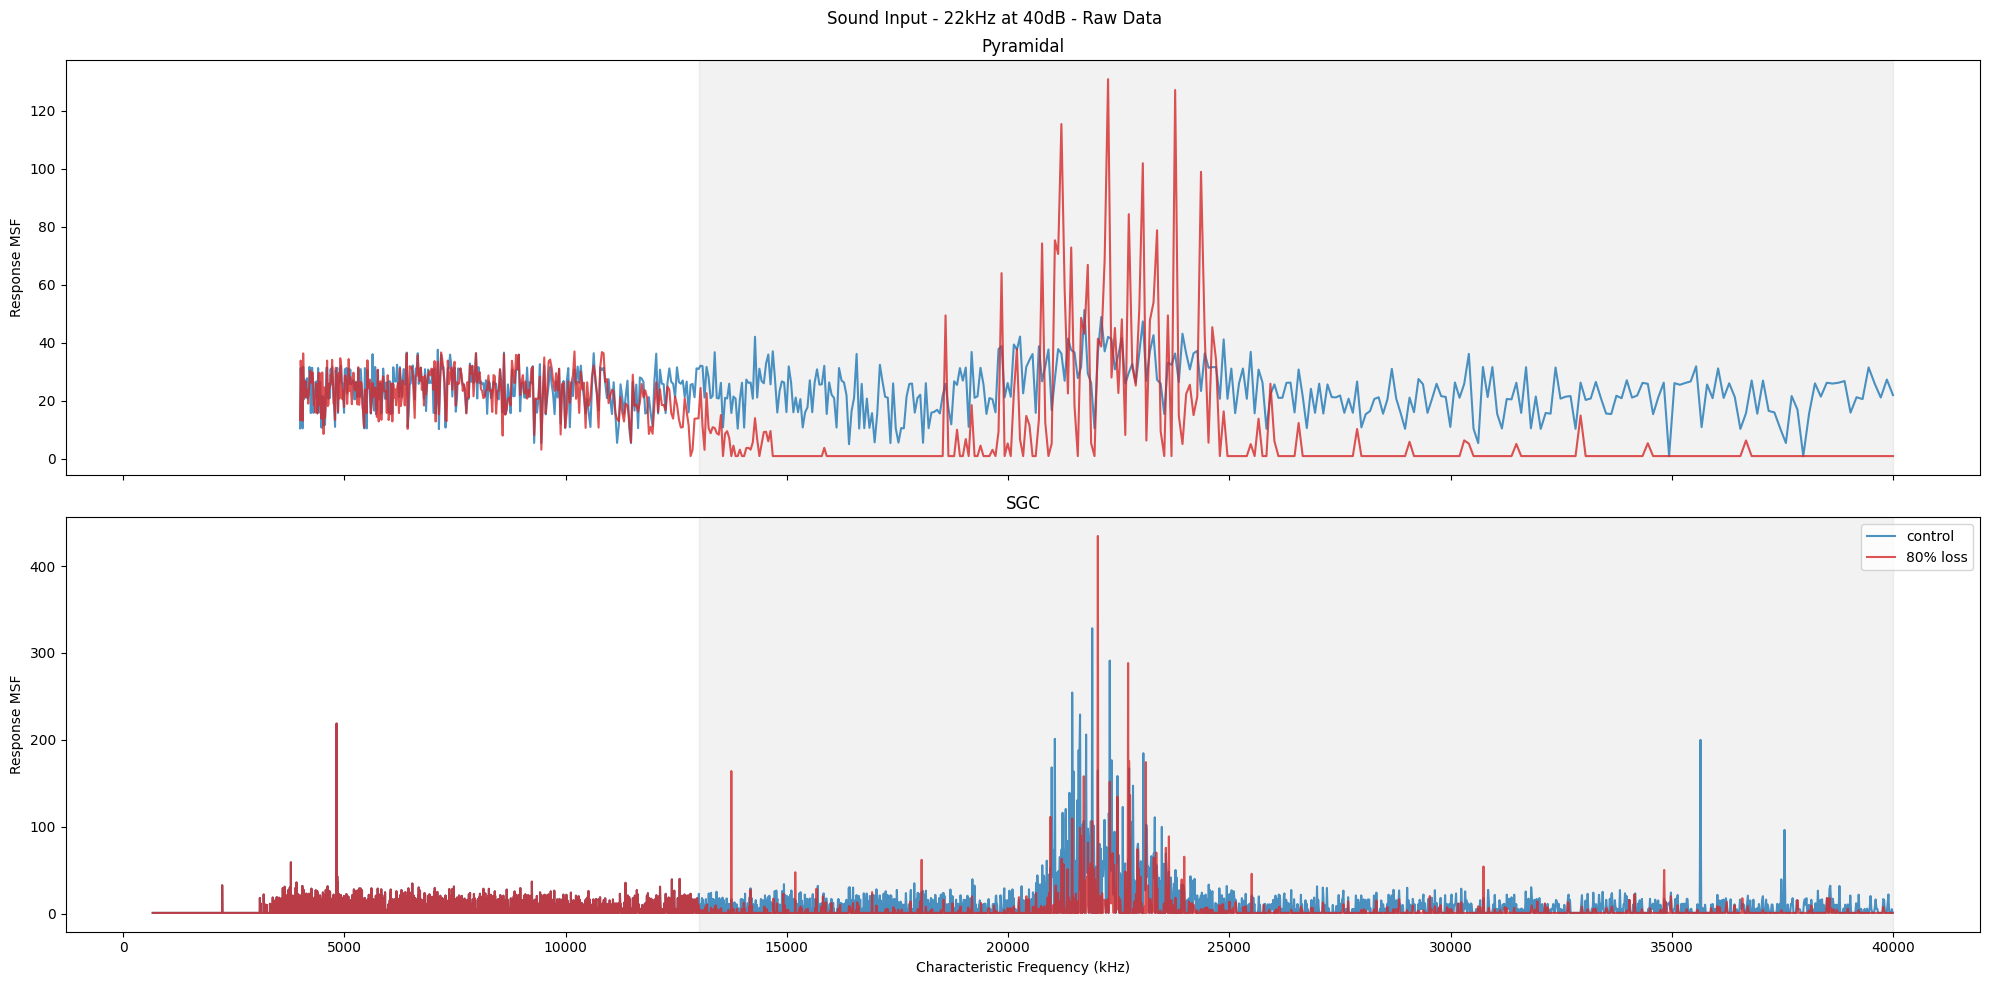

In [43]:
n_cfs = 665
n_reps = 2

results = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs = list(pyr_ids_per_band.keys())
pyr_spont_rates = get_spontaneous_rate('pyramidal', results)
sgc_spont_rates = get_spontaneous_rate('sgc', results)
pyr_ids, pyr_resp_msfs = get_cell_msfs('pyramidal', results, stimpar['response'])
sgc_ids, sgc_resp_msfs = get_cell_msfs('sgc', results, stimpar['response'])

loss_frac = 80
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs_loss = list(pyr_ids_per_band.keys())
pyr_spont_rates_loss = get_spontaneous_rate('pyramidal', results_loss)
sgc_spont_rates_loss = get_spontaneous_rate('sgc', results_loss)
pyr_ids_loss, pyr_resp_msfs_loss = get_cell_msfs('pyramidal', results_loss, stimpar['response'])
sgc_ids_loss, sgc_resp_msfs_loss = get_cell_msfs('sgc', results_loss, stimpar['response'])

fig, axs = plt.subplots(2,1,figsize=(20,10), sharex=True)  #, sharey=True)
axs = axs.ravel()


win_length = 10
polyorder = 3

axs[1].plot(sgc_cfs[sgc_ids], sgc_resp_msfs  , color='tab:blue', zorder=13, alpha=0.8, label='control')
axs[1].set_title('SGC (control)')

axs[1].plot(sgc_cfs[sgc_ids_loss], sgc_resp_msfs_loss  , color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[1].set_title(f"SGC")


axs[0].plot(freqs, pyr_resp_msfs  , color='tab:blue', zorder=13, alpha=0.8, label='control')

axs[0].plot(freqs, pyr_resp_msfs_loss  , color='tab:red', zorder=13, alpha=0.8, label=f'{loss_frac}% loss')
axs[0].set_title(f'Pyramidal')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

for ax in axs:

    # ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    # xtick_span = len(pyr_msfs_loss)//(nticks-1)
    # ax.set_ylim([-10,210])
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

axs[1].legend(loc='upper right')

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Response MSF')
axs[1].set_ylabel('Response MSF')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB - Raw Data")
fig.tight_layout()

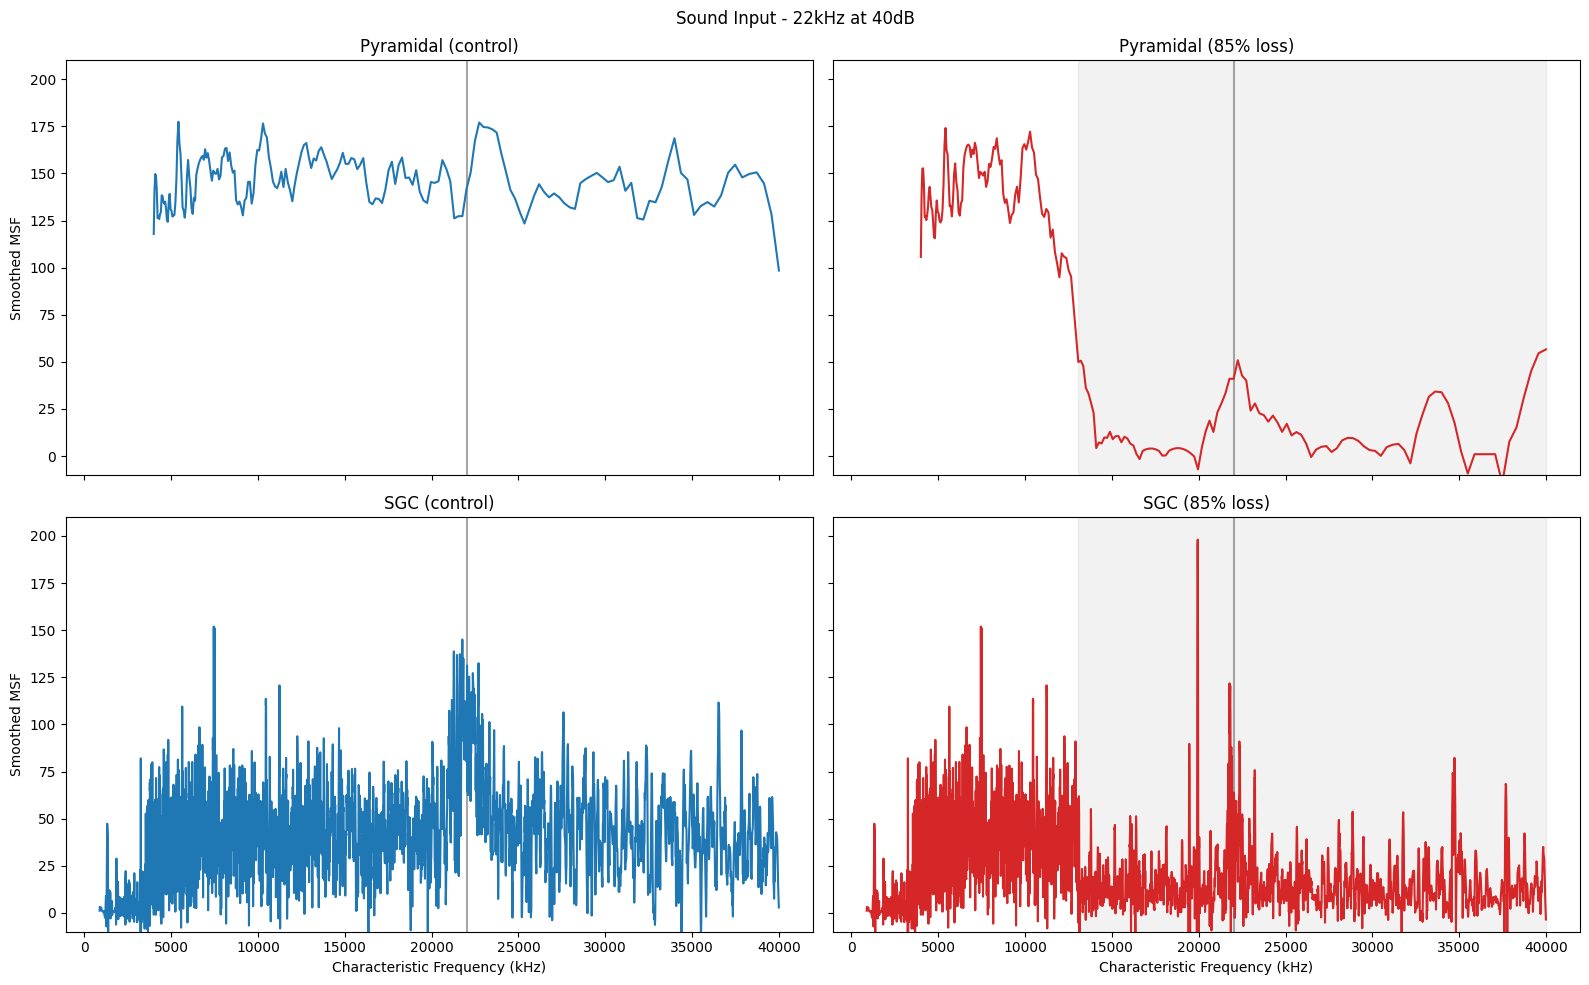

In [66]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs, pyr_msfs = get_pyramidal_msfs(pyr_ids_per_band, results)
sgc_ids, sgc_msfs = get_sgc_msfs(results)

results_loss = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_85/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_85/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs_loss, pyr_msfs_loss = get_pyramidal_msfs(pyr_ids_per_band, results_loss)
sgc_ids_loss, sgc_msfs_loss = get_sgc_msfs(results_loss)

fig, axs = plt.subplots(2,2,figsize=(16,10), sharex=True, sharey=True)
# axs.ravel()

# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

axs[1,0].plot(sgc_cfs[sgc_ids], savgol_filter(sgc_msfs, 10, 3), color='tab:blue', zorder=13)
axs[1,0].set_title('SGC (control)')
axs[1,1].plot(sgc_cfs[sgc_ids_loss], savgol_filter(sgc_msfs_loss, 10, 3), color='tab:red', zorder=13)
axs[1,1].set_title("SGC (85% loss)")

axs[0,0].plot(freqs, savgol_filter(pyr_msfs, 10, 3), color='tab:blue', zorder=13)
axs[0,0].set_title('Pyramidal (control)')
axs[0,1].plot(freqs, savgol_filter(pyr_msfs_loss, 10, 3), color='tab:red', zorder=13)
axs[0,1].set_title('Pyramidal (85% loss)')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

for ax in axs.ravel():

    ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(pyr_msfs_loss)//(nticks-1)
    ax.set_ylim([-10,210])
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

axs[0,1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1,1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0,0].set_ylabel('Smoothed MSF')
axs[1,0].set_ylabel('Smoothed MSF')

axs[1,0].set_xlabel('Characteristic Frequency (kHz)')
axs[1,1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB")
fig.tight_layout()

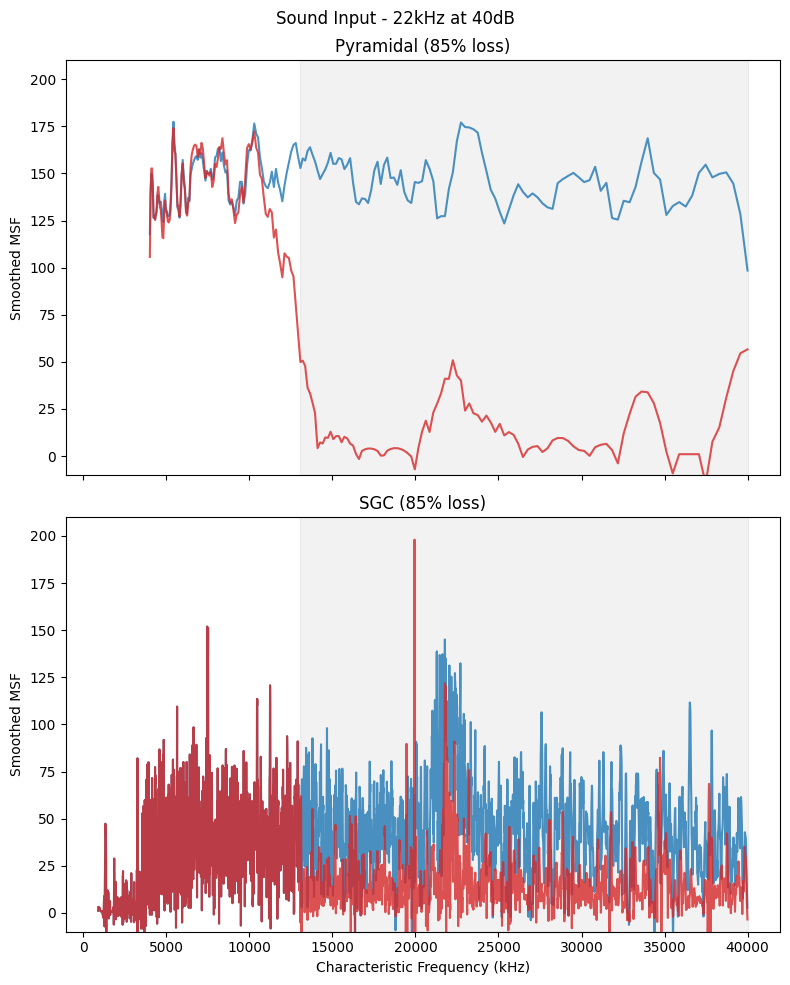

In [ ]:
n_cfs = 665
n_reps = 2

results = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs, pyr_msfs = get_pyramidal_msfs(pyr_ids_per_band, results)
sgc_ids, sgc_msfs = get_sgc_msfs(results)
25
loss_frac = 85
results_loss = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open(f'/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_{loss_frac}/{n_cfs}cfs_1dbs_22000if_1cpb_{n_reps}nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs_loss, pyr_msfs_loss = get_pyramidal_msfs(pyr_ids_per_band, results_loss)
sgc_ids_loss, sgc_msfs_loss = get_sgc_msfs(results_loss)

fig, axs = plt.subplots(2,1,figsize=(8,10), sharex=True, sharey=True)
axs = axs.ravel()

# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

axs[1].plot(sgc_cfs[sgc_ids], savgol_filter(sgc_msfs, 10, 3), color='tab:blue', zorder=13, alpha=0.8)
axs[1].set_title('SGC (control)')
axs[1].plot(sgc_cfs[sgc_ids_loss], savgol_filter(sgc_msfs_loss, 10, 3), color='tab:red', zorder=13, alpha=0.8)
axs[1].set_title(f"SGC ({loss_frac}% loss)")

axs[0].plot(freqs, savgol_filter(pyr_msfs, 10, 3), color='tab:blue', zorder=13, alpha=0.8)
axs[0].set_title('Pyramidal (control)')
axs[0].plot(freqs, savgol_filter(pyr_msfs_loss, 10, 3), color='tab:red', zorder=13, alpha=0.8)
axs[0].set_title(f'Pyramidal ({loss_frac}% loss)')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

for ax in axs:

    # ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(pyr_msfs_loss)//(nticks-1)
    ax.set_ylim([-10,210])
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

axs[0].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Smoothed MSF')
axs[1].set_ylabel('Smoothed MSF')

axs[1].set_xlabel('Characteristic Frequency (kHz)')
axs[1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB")
fig.tight_layout()

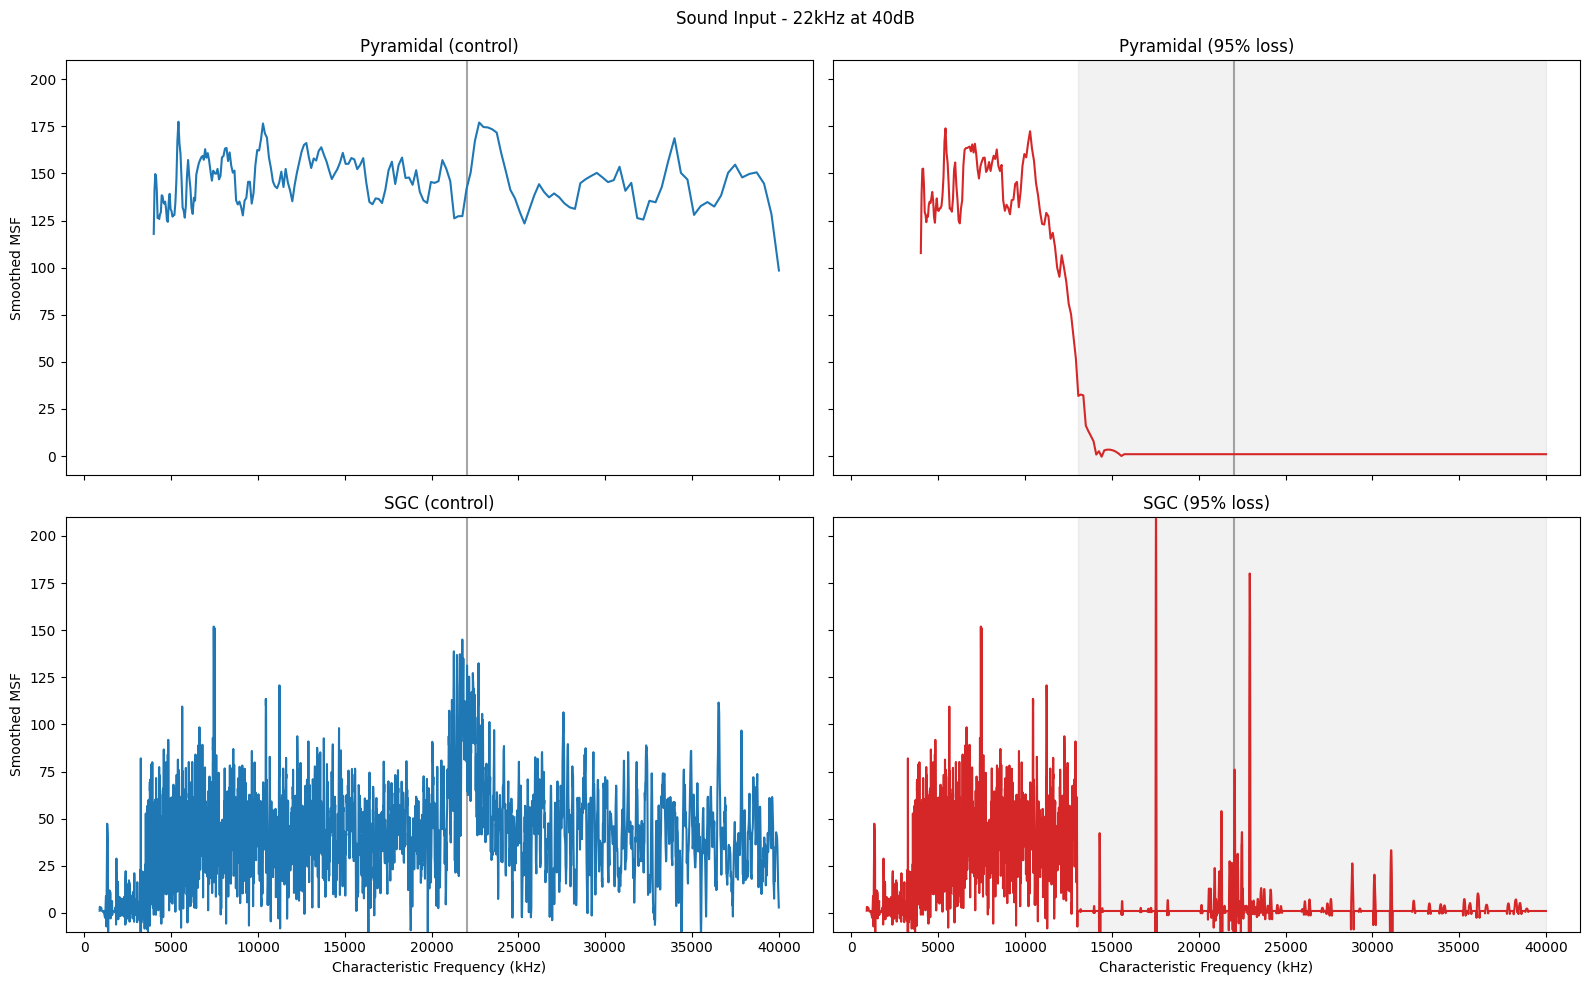

In [65]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs, pyr_msfs = get_pyramidal_msfs(pyr_ids_per_band, results)
sgc_ids, sgc_msfs = get_sgc_msfs(results)

results_loss = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_95/213cfs_1dbs_22000if_1cpb_1nreps/results_df.pkl', 'rb'))
pyr_ids_per_band = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-network_13000loss-m1_95/213cfs_1dbs_22000if_1cpb_1nreps/pyramidal_ids_per_band.pkl', 'rb'))
freqs_loss, pyr_msfs_loss = get_pyramidal_msfs(pyr_ids_per_band, results_loss)
sgc_ids_loss, sgc_msfs_loss = get_sgc_msfs(results_loss)

fig, axs = plt.subplots(2,2,figsize=(16,10), sharex=True, sharey=True)
# axs.ravel()

# axs[0].plot(freqs, n_spikes, color='tab:blue', zorder=12)
# axs[0].plot(freqs, savgol_filter(n_spikes, 10, 3), color='tab:red', zorder=13)
# axs[0].set_ylabel('Number of Spikes')

axs[1,0].plot(sgc_cfs[sgc_ids], savgol_filter(sgc_msfs, 10, 3), color='tab:blue', zorder=13)
axs[1,0].set_title('SGC (control)')
axs[1,1].plot(sgc_cfs[sgc_ids_loss], savgol_filter(sgc_msfs_loss, 10, 3), color='tab:red', zorder=13)
axs[1,1].set_title("SGC (95% loss)")

axs[0,0].plot(freqs, savgol_filter(pyr_msfs, 10, 3), color='tab:blue', zorder=13)
axs[0,0].set_title('Pyramidal (control)')
axs[0,1].plot(freqs, savgol_filter(pyr_msfs_loss, 10, 3), color='tab:red', zorder=13)
axs[0,1].set_title('Pyramidal (95% loss)')

# axs[1,0].set_ylabel('Smoothed MSF')

loss_inds = np.array(freqs)[np.where(np.array(freqs) > 13e3)[0]]

for ax in axs.ravel():

    ax.axvline(freqs[np.abs(np.array(freqs) - input_freq).argmin()], color='grey', alpha=0.7, zorder=2)
    nticks = 6
    xtick_span = len(pyr_msfs_loss)//(nticks-1)
    ax.set_ylim([-10,210])
    # ax.set_xticks([freqs_log[i] for i in [xtick_span*i for i in range(nticks)]])
    # ax.set_xticklabels([round(freqs[i]/1000) for i in [xtick_span*i for i in range(nticks)]])
    
    # ax.set_xlim(left=freqs_log[freqs.index(np.float64(10069.39523082581))]-1000) 

axs[0,1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)
axs[1,1].axvspan(xmin=loss_inds[0], xmax=loss_inds[-1], color='grey', alpha=0.1, zorder=1)

axs[0,0].set_ylabel('Smoothed MSF')
axs[1,0].set_ylabel('Smoothed MSF')

axs[1,0].set_xlabel('Characteristic Frequency (kHz)')
axs[1,1].set_xlabel('Characteristic Frequency (kHz)')

# fig.suptitle(f'Pyramidal Response to {input_freq}Hz at {input_level}dB (85 hearing loss starting at 13kHz)')
fig.suptitle(f"Sound Input - {round(input_freq/1000)}kHz at {input_level}dB")
fig.tight_layout()

## Scratch

In [111]:
sgc_cfs[np.where(sgc_cfs > 13e3)]

array([13000.54320596, 13006.85263942, 13013.16513498, ...,
       39954.88508586, 39974.27602091, 39993.67636679], shape=(2317,))

In [95]:
sgc_cfs

array([  500.        ,   500.24266038,   500.48543852, ...,
       39954.88508586, 39974.27602091, 39993.67636679], shape=(9032,))

In [87]:
len(sgc_ids[0::2])

2630

array([0.5, 1. , 0.5, ..., 0.5, 1. , 0. ], shape=(2630,))

## Normal 1P - 16kHz cf 27kHz if 76 dB

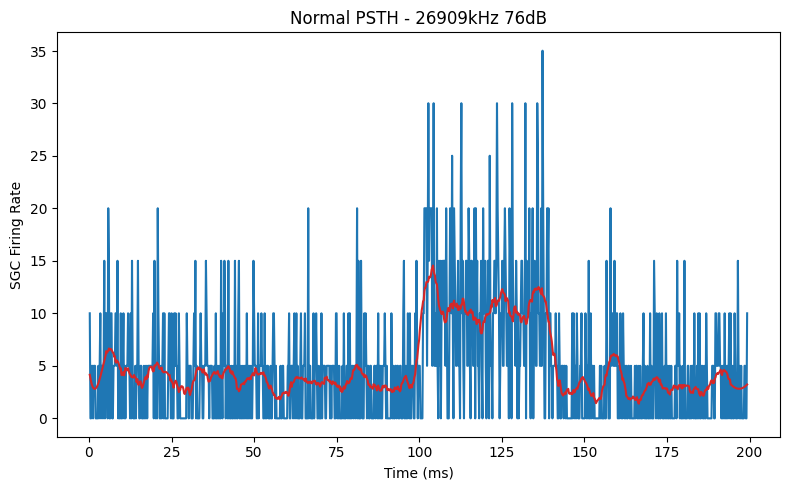

In [80]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell/25fs_11dbs_16000cf-results_od.pkl', 'rb'))

sgc_msfs = []
sgc_spkts = []

freq = 26909
level = 76
stim = f'f0: {freq}  dBspl: {level}'
cells = results[stim][1][0]

for cell_info, cell_data in cells.items():
    if isinstance(cell_info, str):
        continue
    cell_type = cell_info[0]
    cell_id = cell_info[1]
    if 'sgc' in cell_type:

        temp = 8
        spikes = cell_data[1]
        num_spikes = len(spikes)
        num_isi = num_spikes - 1 if num_spikes > 0 else 0
        msf = num_isi / (spikes[-1] - spikes[0])  if num_spikes > 1 else 1
        sgc_msfs.append(msf)
        sgc_spkts.extend(spikes)



sgc_spkts = np.array(sorted(np.array(sgc_spkts)))

bins = np.ceil((sgc_spkts.max() - sgc_spkts.min())/0.2)
y, binedges = np.histogram(sgc_spkts, bins=int(bins))  # returns the right edge of the bins
bincenters = 0.5*(binedges[1:]+binedges[:-1])  # better to use the center of the bins
binsize = bincenters[1] - bincenters[0]  # calculate the width of the bins
rates = y/binsize

fig, axs = plt.subplots(1,1,figsize=(8,5))

axs.plot(bincenters, rates)
axs.plot(bincenters, savgol_filter(rates, 50, 3), color='tab:red')
axs.set_title(f'Normal PSTH - {freq}kHz {level}dB')
axs.set_xlabel('Time (ms)')
axs.set_ylabel('SGC Firing Rate')
fig.tight_layout()

## Loss m1 1P - 16kHz cf 27k Hz if 76 dB

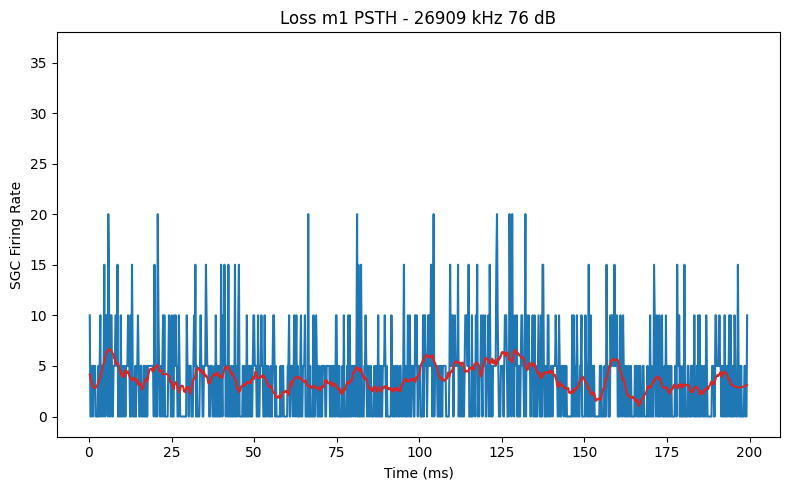

In [79]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell_loss-m1/25fs_11dbs_16000cf-results_od.pkl', 'rb'))

sgc_msfs = []
sgc_spkts = []

freq = 26909
level = 76
stim = f'f0: {freq}  dBspl: {level}'
cells = results[stim][1][0]

for cell_info, cell_data in cells.items():
    if isinstance(cell_info, str):
        continue
    cell_type = cell_info[0]
    cell_id = cell_info[1]
    if 'sgc' in cell_type:

        temp = 8
        spikes = cell_data[1]
        num_spikes = len(spikes)
        num_isi = num_spikes - 1 if num_spikes > 0 else 0
        msf = num_isi / (spikes[-1] - spikes[0])  if num_spikes > 1 else 1
        sgc_msfs.append(msf)
        sgc_spkts.extend(spikes)



sgc_spkts = np.array(sorted(np.array(sgc_spkts)))

bins = np.ceil((sgc_spkts.max() - sgc_spkts.min())/0.2)
y, binedges = np.histogram(sgc_spkts, bins=int(bins))  # returns the right edge of the bins
bincenters = 0.5*(binedges[1:]+binedges[:-1])  # better to use the center of the bins
binsize = bincenters[1] - bincenters[0]  # calculate the width of the bins
rates = y/binsize

fig, axs = plt.subplots(1,1,figsize=(8,5))

axs.plot(bincenters, rates)
axs.plot(bincenters, savgol_filter(rates, 50, 3), color='tab:red')
axs.set_title(f'Loss m1 PSTH - {freq} kHz {level} dB')
axs.set_xlabel('Time (ms)')
axs.set_ylabel('SGC Firing Rate')
axs.set_ylim([-2,38])
fig.tight_layout()

## Loss m2 - 16kHz cf 27kHz if

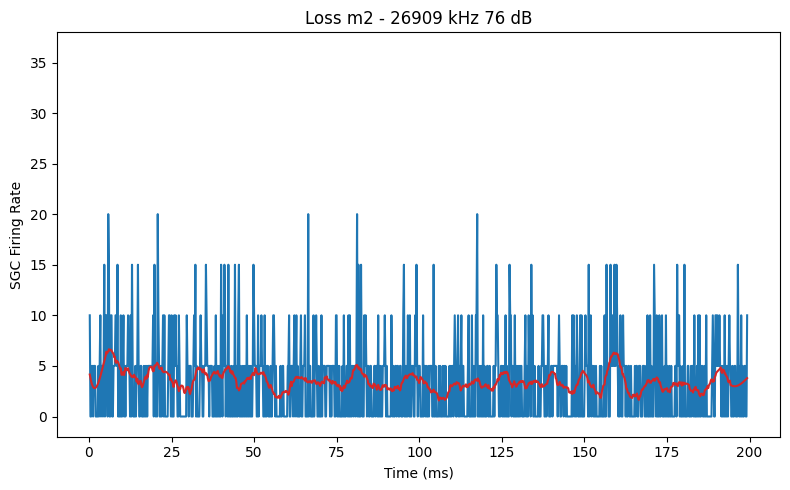

In [78]:
results = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell_loss-m2/25fs_11dbs_16000cf-results_od.pkl', 'rb'))

sgc_msfs = []
sgc_spkts = []

freq = 26909
level = 76
stim = f'f0: {freq}  dBspl: {level}'
cells = results[stim][1][0]

for cell_info, cell_data in cells.items():
    if isinstance(cell_info, str):
        continue
    cell_type = cell_info[0]
    cell_id = cell_info[1]
    if 'sgc' in cell_type:

        temp = 8
        spikes = cell_data[1]
        num_spikes = len(spikes)
        num_isi = num_spikes - 1 if num_spikes > 0 else 0
        msf = num_isi / (spikes[-1] - spikes[0])  if num_spikes > 1 else 1
        sgc_msfs.append(msf)
        sgc_spkts.extend(spikes)

sgc_spkts = np.array(sorted(np.array(sgc_spkts)))

bins = np.ceil((sgc_spkts.max() - sgc_spkts.min())/0.2)
y, binedges = np.histogram(sgc_spkts, bins=int(bins))  # returns the right edge of the bins
bincenters = 0.5*(binedges[1:]+binedges[:-1])  # better to use the center of the bins
binsize = bincenters[1] - bincenters[0]  # calculate the width of the bins
rates = y/binsize

fig, axs = plt.subplots(1,1,figsize=(8,5))

axs.plot(bincenters, rates)
axs.plot(bincenters, savgol_filter(rates, 50, 3), color='tab:red')
axs.set_title(f'Loss m2 - {freq} kHz {level} dB')
axs.set_xlabel('Time (ms)')
axs.set_ylabel('SGC Firing Rate')
axs.set_ylim([-2,38])
fig.tight_layout()